In [1]:
%pylab
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


# 第9章 数据聚合与分组运算


对数据集进行分组并对各组应用一个函数（无论是聚合还是转换），这是数据分析工作中的重要环节。在数据集准备好后，通常任务就是**计算分组统计**或**生成透视表**。

pandas提供了一个灵活高效的groupby功能，以一种自然方式对数据集进行切片、切块、摘要等操作。

本章内容：
- 根据一个或多个键（可以是函数、数组或DataFrame列名）拆分pandas对象。
- 计算分组摘要统计，如技术、平均值、标准拆，或用户自定义函数。
- 对DataFrame的列应用各种函数
- 应用组内转换或其他运算，如规格化、线性回归、排名或选取子集等
- 计算透视表或交叉表
- 执行分位数分析以及其他分组分析

## GroupBy技术
分组运算术语“split-apply-combine”拆分-应用-合并。
1. pandas对象中的数据根据提供的一个或多个键被**拆分**为多组。
2. 将一个函数**应用**到各个分组并产生一个新值。
3. 所有结果被**合并**到最终的结果对象中。

分组键可以有多种形式，且类型不必相同：
- 列表或数组，其长度与待分组的轴一样
- 表示DataFrame某个列名的值
- 字典或Series，给出待分组轴上的值与分组名之间的对应关系
- 函数，用于处理轴索引或索引中的各个标签

In [2]:
# 以表格型数据集为例
df = DataFrame({'key1': ['a', 'a', 'b', 'b', 'a'],
               'key2': ['one', 'two', 'one', 'two', 'one'],
               'data1': np.random.randn(5),
               'data2': np.random.randn(5)})
df

,data1,data2,key1,key2
0,1.059616,2.101625,a,one
1,1.744904,0.052822,a,two
2,-0.468212,-0.641095,b,one
3,0.173817,0.627965,b,two
4,-0.375410,-0.505750,a,one


In [3]:
# 按key1分组，并计算data1列的平均值
# 访问data1，根据key1调用groupby
grouped = df['data1'].groupby(df['key1'])
grouped
# grouped是一个GroupBy对象，但没有进行任何计算，只含有一些有关分组键df['key1']的中间数据
# 换句话说，该对象已经有了接下来对各分组执行运算所需的一切信息。

In [4]:
# 调用GroupBy对象的mean方法来计算平均值
grouped.mean()

key1
a    0.809703
b   -0.147197
Name: data1, dtype: float64

In [5]:
# 一次传入多个数组：
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one     0.342103
      two     1.744904
b     one    -0.468212
      two     0.173817
Name: data1, dtype: float64

In [6]:
# unstack()行-》列，默认操作最内级
means.unstack()

key2,one,two
key1,,
a,0.342103,1.744904
b,-0.468212,0.173817


In [7]:
# 分组键不仅为Series，可以为任何长度适当的数组：
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])

df['data1'].groupby([states, years]).mean()

California  2005    1.744904
            2006   -0.468212
Ohio        2005    0.616717
            2006   -0.375410
Name: data1, dtype: float64

In [8]:
# GroupBy的size方法，返回一个含有分组大小的Series：
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

### 对分组进行迭代
GroupBy对象支持迭代，可以产生一组二元元组（由分组名和数据块组成）

for name, group in df.groupby('key1'):
    print name
    print group

对于多重键的情况，元组的第一个元素将会是由键值组成的元组：

In [9]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print k1, k2
    print group

a one
      data1     data2 key1 key2
0  1.059616  2.101625    a  one
4 -0.375410 -0.505750    a  one
a two
      data1     data2 key1 key2
1  1.744904  0.052822    a  two
b one
      data1     data2 key1 key2
2 -0.468212 -0.641095    b  one
b two
      data1     data2 key1 key2
3  0.173817  0.627965    b  two


In [10]:
# 将这些数据片段做成一个字典
pieces = dict(list(df.groupby('key1')))
pieces['a']

,data1,data2,key1,key2
0,1.059616,2.101625,a,one
1,1.744904,0.052822,a,two
4,-0.375410,-0.505750,a,one


groupby默认在axis=0上进行分组，设置后可以在其他任何轴上分组。根据dtype对列进行分组：

In [11]:
df.dtypes

data1    float64
data2    float64
key1      object
key2      object
dtype: object

In [12]:
grouped = df.groupby(df.dtypes, axis=1)

In [13]:
dict(list(grouped))

{dtype('float64'):       data1     data2
 0  1.059616  2.101625
 1  1.744904  0.052822
 2 -0.468212 -0.641095
 3  0.173817  0.627965
 4 -0.375410 -0.505750, dtype('O'):   key1 key2
 0    a  one
 1    a  two
 2    b  one
 3    b  two
 4    a  one}

### 选择一个或一组列
用一个或一组列名对DataFrame产生的GroupBy对象进行索引，就行实现选取部分列进行聚合的目的。
```
df.groupby('key1')['data1']
df.groupby('key1')[['data2']]
```
是一下代码的语法糖：
```
df['data1'].groupby(df['key1'])
df[['data2']].groupby(df['key1'])
```

In [14]:
# 计算data2列的平均值并以DataFrame形式得到结果：
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one   0.797937
     two   0.052822
b    one  -0.641095
     two   0.627965

### 通过字典或Series进行分组
除数组外，分组信息还可以其他形式存在。

In [15]:
people = DataFrame(np.random.randn(5, 5),
                  columns=['a', 'b', 'c', 'd', 'e'],
                  index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])

people.ix[2:3, ['b', 'c']] = np.nan # 添加几个NA值
people

,a,b,c,d,e
Joe,0.417125,-2.233563,2.671638,-0.210931,0.728721
Steve,0.139254,-0.974540,0.854429,-0.483635,0.457716
Wes,0.799517,NaN,NaN,-0.839905,0.631172
Jim,-1.371422,0.164642,-1.061582,1.225734,0.922490
Travis,-0.351710,-0.622227,0.945457,0.961790,3.081858


In [16]:
# 已知列的分组关系，并希望根据分组计算列的总计：
mapping = {'a': 'red', 'b': 'red', 'c': 'blue', 'd': 'blue', 'e': 'red', 'f': 'orange'}

# 将字典传给groupby
by_column = people.groupby(mapping, axis=1)
by_column.sum()

,blue,red
Joe,2.460707,-1.087717
Steve,0.370795,-0.377570
Wes,-0.839905,1.430689
Jim,0.164153,-0.284290
Travis,1.907247,2.107921


Series也有同样的功能，它可以被看做一个固定大小的映射。对于上面那个例子，如果Series作为分组键，则pandas会检查Series以确保其索引跟分组轴是对齐的：

In [17]:
map_series = Series(mapping)
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [18]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


### 通过函数进行分组
任何被当做分组键的函数都会在各个索引值上被调用一次，其返回值就会被用作分组名称。

以上节为例，其索引值为人的名字，希望根据人名长度进行分组，虽然可以求取一个字符串长度数组，但其实仅仅传入len函数就可以了：

In [19]:
people.groupby(len).sum()

,a,b,c,d,e
3,-0.154780,-2.068921,1.610057,0.174898,2.282383
5,0.139254,-0.974540,0.854429,-0.483635,0.457716
6,-0.351710,-0.622227,0.945457,0.961790,3.081858


将函数跟数组、列表、字典、Series混合使用也不是问题，因为任何东西最终都会被转换为数组：

In [20]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one  0.417125 -2.233563  2.671638 -0.839905  0.631172
  two -1.371422  0.164642 -1.061582  1.225734  0.922490
5 one  0.139254 -0.974540  0.854429 -0.483635  0.457716
6 two -0.351710 -0.622227  0.945457  0.961790  3.081858

### 根据索引级别分组
通过level关键字传入级别编号或名称即可：

In [21]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                    [1, 3, 5, 1, 3]], names=['cty', 'tenor'])

In [22]:
hier_df = DataFrame(np.random.randn(4,5), columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0     -2.785820  0.868967 -0.583744 -0.852757  1.061870
1      0.588549 -0.409792  1.336347 -0.327303 -0.452961
2      1.146551  1.124899  0.050188 -2.054244  0.079007
3     -1.438552 -0.250766  1.505564  0.866805 -0.576204

In [23]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


## 数据聚合
聚合：任何能够从数组产生标量值得数据转换过程。之前的例子比如mean、count、min以及sum等。

**经过优化的GroupBy的方法**

**函数名** | **说明**
- | -
count | 分组中非NA值的数量
sum | 非NA值的和
mean | 非NA值得平均值
median | 非NA值得算数中位数
std、var | 无偏（分母n-1）标准差和方差
min、max | 非NA值得最小和最大值
prod | 非NA值的积
first、last | 第一个和最后一个非NA值

也可以使用自己发明的聚合运算。

运行方式，例如quantile，没有明确地实现于GroupBy，但它是一个Series方法，所以这里是能用的。GroupBy会高效地对Seris进行切片，然后对各片调用piece.quantile()，最后将这些结果组装成最终结果。

如果要使用自己的聚合函数，只需将其传入aggregate或agg方法即可：

In [24]:
def peak_to_peak(arr):
    return arr.max() - arr.min()

grouped = df.groupby('key1')
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,2.120314,2.607374
b,0.642029,1.269059


In [25]:
# 有些方法也可以在这里用，即使不是聚合运算：
grouped.describe()

data1     data2
key1                          
a    count  3.000000  3.000000
     mean   0.809703  0.549566
     std    1.082024  1.372831
     min   -0.375410 -0.505750
     25%    0.342103 -0.226464
     50%    1.059616  0.052822
     75%    1.402260  1.077223
     max    1.744904  2.101625
b    count  2.000000  2.000000
     mean  -0.147197 -0.006565
     std    0.453983  0.897360
     min   -0.468212 -0.641095
     25%   -0.307704 -0.323830
     50%   -0.147197 -0.006565
     75%    0.013310  0.310700
     max    0.173817  0.627965

**注意：**自定义的聚合函数要比优化过的表中的函数慢很多，因为在构造中间分组数据块时存在非常大的开销（函数调用、数据重排等）。

### 面向列的多函数应用
对不同的列使用不同的聚合函数，或一次应用多个函数。首先根据sex和smoker对tips进行分组：

In [26]:
tips = pd.read_csv('old-file/ch08/tips.csv')

# 添加“消费占总额百分比”的列
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips[:5]

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808


In [27]:
grouped = tips.groupby(['sex', 'smoker']) # 多层次索引的DataFrame
grouped_pct = grouped['tip_pct'] # 多层次索引的Series

grouped_pct.agg('mean')

sex     smoker
Female  No        0.156921
        Yes       0.182150
Male    No        0.160669
        Yes       0.152771
Name: tip_pct, dtype: float64

In [28]:
# 传入一组函数或函数名，的到的DataFrame的列就会以相应的函数命名：
grouped_pct.agg(['mean', 'std', peak_to_peak])

mean       std  peak_to_peak
sex    smoker                                  
Female No      0.156921  0.036421      0.195876
       Yes     0.182150  0.071595      0.360233
Male   No      0.160669  0.041849      0.220186
       Yes     0.152771  0.090588      0.674707

不一定接受GroupBy自动给出的列名，特别是lambda函数，名称为'<lambda>',如果传入的是一个由***(name, function)***元组组成的列表，则各元组的第一个元素就会被用作DataFrame的列名（可以将这种二元元组列表看做一个有序映射）：

In [29]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std), ('ptp', peak_to_peak)])

foo       bar       ptp
sex    smoker                              
Female No      0.156921  0.036421  0.195876
       Yes     0.182150  0.071595  0.360233
Male   No      0.160669  0.041849  0.220186
       Yes     0.152771  0.090588  0.674707

In [30]:
# 一组应用于全部列的函数，或不同的列应用不同的函数。
functions = ['count', 'mean', 'max']
result = grouped['tip_pct', 'total_bill'].agg(functions)

result

tip_pct                     total_bill                  
                count      mean       max      count       mean    max
sex    smoker                                                         
Female No          54  0.156921  0.252672         54  18.105185  35.83
       Yes         33  0.182150  0.416667         33  17.977879  44.30
Male   No          97  0.160669  0.291990         97  19.791237  48.33
       Yes         60  0.152771  0.710345         60  22.284500  50.81

In [31]:
# DataFrame拥有层次化的列，这相当于分别对各列进行聚合，然后用concat将结果组装到一起
result['tip_pct']

count      mean       max
sex    smoker                           
Female No         54  0.156921  0.252672
       Yes        33  0.182150  0.416667
Male   No         97  0.160669  0.291990
       Yes        60  0.152771  0.710345

In [32]:
# 可以传入带有自定义名称的元组列表
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]
grouped['tip_pct', 'total_bill'].agg(ftuples)

tip_pct              total_bill           
              Durchschnitt Abweichung Durchschnitt Abweichung
sex    smoker                                                
Female No         0.156921   0.001327    18.105185  53.092422
       Yes        0.182150   0.005126    17.977879  84.451517
Male   No         0.160669   0.001751    19.791237  76.152961
       Yes        0.152771   0.008206    22.284500  98.244673

In [33]:
# 不用的列应用不同的函数，向agg传入一个从列名映射到函数的字典：
grouped.agg({'tip': np.max, 'size': 'sum'})

tip  size
sex    smoker            
Female No       5.2   140
       Yes      6.5    74
Male   No       9.0   263
       Yes     10.0   150

In [34]:
grouped.agg({'tip_pct': ['min', 'max', 'mean', 'std'], # 对tip_pct这列应用四个不同的函数，返回四个结果
            'size': 'sum'})

tip_pct                               size
                    min       max      mean       std  sum
sex    smoker                                             
Female No      0.056797  0.252672  0.156921  0.036421  140
       Yes     0.056433  0.416667  0.182150  0.071595   74
Male   No      0.071804  0.291990  0.160669  0.041849  263
       Yes     0.035638  0.710345  0.152771  0.090588  150

### 以“无索引”的形式返回聚合数据
向groupby传入as_index=False以禁用该功能，但是这种用法比较缺乏灵活性

In [35]:
tips.groupby(['sex', 'smoker'], as_index=False).mean()

,sex,smoker,total_bill,tip,size,tip_pct
0,Female,No,18.105185,2.773519,2.592593,0.156921
1,Female,Yes,17.977879,2.931515,2.242424,0.182150
2,Male,No,19.791237,3.113402,2.711340,0.160669
3,Male,Yes,22.284500,3.051167,2.500000,0.152771


## 分组级运算和转换
聚合是分组运算中的一种而已。是数据转换的一个特例，也就是说，它接受能够将一维数组简化为标量值的函数。本节介绍transform和apply方法，能执行更多的分组运算。

例子，为一个DataFrame添加一个用于存放各个索引分组平均值的列，一个办法是先聚合再合并：

In [36]:
df

,data1,data2,key1,key2
0,1.059616,2.101625,a,one
1,1.744904,0.052822,a,two
2,-0.468212,-0.641095,b,one
3,0.173817,0.627965,b,two
4,-0.375410,-0.505750,a,one


In [37]:
k1_means = df.groupby('key1').mean().add_prefix('mean_')
k1_means

,mean_data1,mean_data2
key1,,
a,0.809703,0.549566
b,-0.147197,-0.006565


In [38]:
pd.merge(df, k1_means, left_on='key1', right_index=True) # 左侧DF中用作连接键的列为key1，右侧行索引用作其连接键

,data1,data2,key1,key2,mean_data1,mean_data2
0,1.059616,2.101625,a,one,0.809703,0.549566
1,1.744904,0.052822,a,two,0.809703,0.549566
4,-0.375410,-0.505750,a,one,0.809703,0.549566
2,-0.468212,-0.641095,b,one,-0.147197,-0.006565
3,0.173817,0.627965,b,two,-0.147197,-0.006565


In [39]:
# tansform方法
key = ['one', 'two', 'one', 'two', 'one']
people.groupby(key).mean()

,a,b,c,d,e
one,0.288311,-1.427895,1.808547,-0.029682,1.480584
two,-0.616084,-0.404949,-0.103576,0.371050,0.690103


In [40]:
people.groupby(key).transform(np.mean) # tansform将np.mean应用到各个分组上，然后将结果放到适当的位置上

,a,b,c,d,e
Joe,0.288311,-1.427895,1.808547,-0.029682,1.480584
Steve,-0.616084,-0.404949,-0.103576,0.371050,0.690103
Wes,0.288311,-1.427895,1.808547,-0.029682,1.480584
Jim,-0.616084,-0.404949,-0.103576,0.371050,0.690103
Travis,0.288311,-1.427895,1.808547,-0.029682,1.480584


从各组中减去平均值，先创建一个距平化函数（demeaning function），然后传给transform

In [41]:
def demean(arr):
    return arr - arr.mean()

demeaned = people.groupby(key).transform(demean)
demeaned

,a,b,c,d,e
Joe,0.128814,-0.805668,0.863091,-0.181249,-0.751863
Steve,0.755338,-0.569591,0.958006,-0.854684,-0.232387
Wes,0.511207,NaN,NaN,-0.810223,-0.849412
Jim,-0.755338,0.569591,-0.958006,0.854684,0.232387
Travis,-0.640021,0.805668,-0.863091,0.991472,1.601274


In [42]:
# 姜茶demeaned的分组平均值是否为0：
demeaned.groupby(key).mean()

,a,b,c,d,e
one,0.0,-5.551115e-17,1.110223e-16,-3.700743e-17,0.000000e+00
two,0.0,0.000000e+00,0.000000e+00,0.000000e+00,5.551115e-17


### apply: 一般性的“拆分-应用-合并”

跟aggregate一样，tansform也是一个有条件限制的特殊函数：传入的函数只能产生两种结果，要么产生一个可以广播的标量值（如np.mean），要么产生一个相同大小的结果数组。

最一般化的GroupBy方法是apply。

回到小费数据集，根据分组选出最高的5个tip_pct值。

In [43]:
# 在指定列找出最大值，然后把这个值所在的行选取出来
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]

In [44]:
top(tips, n=6)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


In [45]:
# 如果对smoker分组并用该函数调用apply：
tips.groupby('smoker').apply(top)

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

> 这里发生了什么？

top函数在DF的各个片段上调用（此处为smoker分类的两个片段），然后结果由pandas.concat组装到一起，并以分组名称进行了标记，于是，最终结果就有了一个层次化索引，其内层索引值来自原DF。

如果传给apply的函数能够接受其他参数或关键字，则可以将这些内容放在函数名后面一并传入：

In [46]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

total_bill    tip     sex smoker   day    time  size  \
smoker day                                                              
No     Fri  94        22.75   3.25  Female     No   Fri  Dinner     2   
       Sat  212       48.33   9.00    Male     No   Sat  Dinner     4   
       Sun  156       48.17   5.00    Male     No   Sun  Dinner     6   
       Thur 142       41.19   5.00    Male     No  Thur   Lunch     5   
Yes    Fri  95        40.17   4.73    Male    Yes   Fri  Dinner     4   
       Sat  170       50.81  10.00    Male    Yes   Sat  Dinner     3   
       Sun  182       45.35   3.50    Male    Yes   Sun  Dinner     3   
       Thur 197       43.11   5.00  Female    Yes  Thur   Lunch     4   

                  tip_pct  
smoker day                 
No     Fri  94   0.142857  
       Sat  212  0.186220  
       Sun  156  0.103799  
       Thur 142  0.121389  
Yes    Fri  95   0.117750  
       Sat  170  0.196812  
       Sun  182  0.077178  
       Thur 197  0.115982

在GroupBy中，当你调用诸如describe之类的方法时，实际上只是应用了下面两条代码的快捷方式而已：
```python
f = lambda x: x.describe()
grouped.apply(f)
```

In [47]:
result = tips.groupby('smoker')['tip_pct'].describe()
result

smoker       
No      count    151.000000
        mean       0.159328
        std        0.039910
        min        0.056797
        25%        0.136906
        50%        0.155625
        75%        0.185014
        max        0.291990
Yes     count     93.000000
        mean       0.163196
        std        0.085119
        min        0.035638
        25%        0.106771
        50%        0.153846
        75%        0.195059
        max        0.710345
Name: tip_pct, dtype: float64

**禁止分组键**

分组键会跟原始对象的索引共同构成结果对象中的层次化索引。将group_keys=False传入groupby可禁止：

In [48]:
tips.groupby('smoker', group_keys=False).apply(top) # 还是可以看出是两个片段的排序

,total_bill,tip,sex,smoker,day,time,size,tip_pct
88,24.71,5.85,Male,No,Thur,Lunch,2,0.236746
185,20.69,5.00,Male,No,Sun,Dinner,5,0.241663
51,10.29,2.60,Female,No,Sun,Dinner,2,0.252672
149,7.51,2.00,Male,No,Thur,Lunch,2,0.266312
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


### 分位数和桶分析
pandas根据指定面元或样本分位数将数据拆分为多块的工具（如cut、qcut）。将这些函数跟groupby结合起来，就能非常轻松地实现对数据集的**桶（bucket）或分位数（quantile）分析**了。

以随机数据集为例，利用cut将其装入长度相等的bucket中：

In [49]:
frame = DataFrame({'data1': np.random.randn(1000),
                  'data2': np.random.randn(1000)})

factor = pd.cut(frame.data1, 4)

factor[:10]

0        (-1.385, 0.223]
1        (-1.385, 0.223]
2         (0.223, 1.832]
3        (-1.385, 0.223]
4        (-1.385, 0.223]
5        (-1.385, 0.223]
6          (1.832, 3.44]
7        (-1.385, 0.223]
8    (-3.000443, -1.385]
9         (0.223, 1.832]
Name: data1, dtype: category
Categories (4, object): [(-3.000443, -1.385] < (-1.385, 0.223] < (0.223, 1.832] < (1.832, 3.44]]

由cut返回的Factor对象可直接用于groupby，可以这样对data2做一些统计计算：

In [50]:
def get_stats(group):
    return{'min': group.min(), 'max': group.max(),
           'count': group.count(), 'mean': group.mean()}

grouped = frame.data2.groupby(factor)

grouped.apply(get_stats)

data1                     
(-3.000443, -1.385]  count     82.000000
                     max        2.199967
                     mean       0.010514
                     min       -2.572605
(-1.385, 0.223]      count    517.000000
                     max        2.375844
                     mean      -0.023616
                     min       -3.696233
(0.223, 1.832]       count    365.000000
                     max        2.699716
                     mean       0.003472
                     min       -2.782803
(1.832, 3.44]        count     36.000000
                     max        2.982842
                     mean       0.189362
                     min       -2.732206
Name: data2, dtype: float64

In [51]:
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-3.000443, -1.385]",82.0,2.199967,0.010514,-2.572605
"(-1.385, 0.223]",517.0,2.375844,-0.023616,-3.696233
"(0.223, 1.832]",365.0,2.699716,0.003472,-2.782803
"(1.832, 3.44]",36.0,2.982842,0.189362,-2.732206


上面是长度相等的bucket（data1区域的范围相同），要根据样本分位数等到大小相等的bucket，使用qcut，传入labels=False即可只获取分位数的编号：

In [52]:
grouping = pd.qcut(frame.data1, 5, labels=False) # data2的数据值和data1的区间没有关系
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,200.0,2.199967,-0.026173,-2.572605
1,200.0,2.155190,-0.062917,-3.696233
2,200.0,2.375844,0.029182,-3.181375
3,200.0,2.402644,0.039534,-1.882378
4,200.0,2.982842,0.004058,-2.782803


### 示例：用特定于分组的值填充缺失值

对于缺失数据，有时用dropna滤除，有时用衍生值去填充，用fillna工具，如用平均值去填充NA值：

In [53]:
s = Series(np.random.randn(6))
s[::2] = np.nan
s

0         NaN
1   -0.762960
2         NaN
3    0.763926
4         NaN
5    0.915411
dtype: float64

In [54]:
s.fillna(s.mean())

0    0.305459
1   -0.762960
2    0.305459
3    0.763926
4    0.305459
5    0.915411
dtype: float64

对不同的分组填充不同的值：
将数据分组，并使用apply和一个能够对各数据块调用fillna的函数即可。

下面是美国州示例，这些州分为东西部：

In [55]:
states = ['Ohio', 'New York', 'Vermont', 'Florida', 'Oregon',
          'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4
data = Series(np.random.randn(8), index=states)
data[['Vermont', 'Nevada', 'Idaho']] = np.nan

data

Ohio         -0.627377
New York     -0.046128
Vermont            NaN
Florida      -1.343471
Oregon        0.224943
Nevada             NaN
California    0.167926
Idaho              NaN
dtype: float64

In [56]:
data.groupby(group_key).mean()

East   -0.672326
West    0.196435
dtype: float64

In [57]:
# 用分组平均值去填充NA值
fill_mean = lambda g: g.fillna(g.mean())

data.groupby(group_key).apply(fill_mean) # g表示East或West的分组

Ohio         -0.627377
New York     -0.046128
Vermont      -0.672326
Florida      -1.343471
Oregon        0.224943
Nevada        0.196435
California    0.167926
Idaho         0.196435
dtype: float64

In [58]:
# 预定义各组的填充值，分组具有一个name属性，可以调用
fill_values = {'East': 0.5, 'West': -1}
fill_func = lambda g: g.fillna(fill_values[g.name])

data.groupby(group_key).apply(fill_func)

Ohio         -0.627377
New York     -0.046128
Vermont       0.500000
Florida      -1.343471
Oregon        0.224943
Nevada       -1.000000
California    0.167926
Idaho        -1.000000
dtype: float64

### 示例：随机采样和排列
从一个大数据集中随机抽取样本以进行蒙特卡罗模拟（Monte Carlo simulation）或其他分析工作。“抽取”的方式有很多，其中一些的效率会比其他的高很多。一个办法是，选取np.random.permutation(N)的前K个元素，其中N为完整数据的大小，K为期望的样本大小。

作为例子，下面是构造一副英语型扑克牌的一个方式：

In [59]:
# 红桃Hearts 黑桃Spades 梅花Clubs 方片Diamonds
suits = ['H', 'S', 'C', 'D']
card_val = (range(1,11) + [10] * 3) * 4
base_names = ['A'] + range(2, 11) + ['J', 'Q', 'K']
cards = []
for suit in suits:
    cards.extend(str(num) + suit for num in base_names)
    
deck = Series(card_val, index=cards) # 一个长度为52的Series，索引为牌名

In [60]:
# 现在，从整副牌中抽出5张：
def draw(deck, n=5):
    return deck.take(np.random.permutation(len(deck))[:n])

draw(deck)

9C     9
6D     6
9D     9
KD    10
8C     8
dtype: int64

从每种花色中随机抽取两张牌，由于花色是牌名的最后一个字符，可以依据此进行分组，并使用apply：

In [61]:
get_suit = lambda card: card[-1] # 取最后一个字母
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

10C    10
8C      8
QD     10
5D      5
JH     10
5H      5
3S      3
KS     10
dtype: int64

### 示例：分组加权平均数和相关系数
根据groupby的“拆分-应用-合并”范式，DF的列与列之间或两个Series之间的运算（如分组加权平均）成为一种标准作业。

以下面这个数据集为例，它含有分组键，值以及一些权重值：

In [62]:
df = DataFrame({'category': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'],
               'data': np.random.randn(8),
               'weights': np.random.rand(8)})
df

,category,data,weights
0,a,-0.493908,0.137900
1,a,1.392782,0.629874
2,a,-0.059717,0.750037
3,a,1.843943,0.631012
4,b,-1.073697,0.260284
5,b,0.830075,0.502837
6,b,-1.163834,0.808145
7,b,0.377759,0.687271


In [63]:
# 利用category计算分组加权平均数：
grouped = df.groupby('category')
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])
grouped.apply(get_wavg)

category
a    0.897202
b   -0.240420
dtype: float64

In [64]:
# 实际例子，yahoo的数据集
# 其中含有标准普尔500指数（SPX字段）和几只股票的收盘价：
close_px = pd.read_csv('old-file/ch09/stock_px.csv', parse_dates=True, index_col=0)

close_px[-4:]

,AAPL,MSFT,XOM,SPX
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


In [65]:
# 计算一个由日收益率（通过百分比数变化计算）与SPX之间的年度相关系数组成的DF
rets = close_px.pct_change().dropna()
spx_corr = lambda x: x.corrwith(x['SPX'])
by_year = rets.groupby(lambda x: x.year)
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


In [66]:
# 苹果和微软的年度相关系数
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### 示例：面向分组的线性回归
定义regress函数（利用statsmodels库）对各类数据块执行普通最小二乘法（Ordinary Least Square， OLS）回归：

In [67]:
import statsmodels.api as sm
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

In [68]:
# 按年计算AAPL对SPX收益率的线性回归
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


## 透视表和交叉表
透视表（pivot table）：常见的数据汇总工具，根据一个或多个键对数据进行聚合，并根据行和列上的分组键将数据分配到各个矩形区域中。

在python和pandas中没有groupby功能以及重塑运算制作透视表。DF有一个pivot_table方法，此外还有一个顶级的pandas.pivot_table函数。除能为groupby提供便利之外，pivot_table还可以添加分项小计（也叫作margins）。

回到小费数据集，根据sex和smoker计算分组平均数（pivot_table默认聚合类型），并将sex和smoker放到行上：

In [70]:
tips.pivot_table(index=['sex', 'smoker'])

size       tip   tip_pct  total_bill
sex    smoker                                          
Female No      2.592593  2.773519  0.156921   18.105185
       Yes     2.242424  2.931515  0.182150   17.977879
Male   No      2.711340  3.113402  0.160669   19.791237
       Yes     2.500000  3.051167  0.152771   22.284500

In [71]:
# 用groupby实现也简单，配合mean()
# 只聚合tip_pct和size,根据day分组，smoker放到列上，把day放行上：
tips.pivot_table(['tip_pct', 'size'], index=['sex', 'day'], columns='smoker')

tip_pct                size          
smoker             No       Yes        No       Yes
sex    day                                         
Female Fri   0.165296  0.209129  2.500000  2.000000
       Sat   0.147993  0.163817  2.307692  2.200000
       Sun   0.165710  0.237075  3.071429  2.500000
       Thur  0.155971  0.163073  2.480000  2.428571
Male   Fri   0.138005  0.144730  2.000000  2.125000
       Sat   0.162132  0.139067  2.656250  2.629630
       Sun   0.158291  0.173964  2.883721  2.600000
       Thur  0.165706  0.164417  2.500000  2.300000

In [72]:
# 传入margins=True添加分项小计，将会添加标签为All的行和列，其值对应于单个等级中所有数据的分组统计
# 下面这个All值为平均数，不单独考虑烟民和非烟民（All列），不单独考虑行分组两个级别中的任何单项（All行）
tips.pivot_table(['tip_pct', 'size'], index=['sex', 'day'], columns='smoker', margins=True)

tip_pct                          size                    
smoker             No       Yes       All        No       Yes       All
sex    day                                                             
Female Fri   0.165296  0.209129  0.199388  2.500000  2.000000  2.111111
       Sat   0.147993  0.163817  0.156470  2.307692  2.200000  2.250000
       Sun   0.165710  0.237075  0.181569  3.071429  2.500000  2.944444
       Thur  0.155971  0.163073  0.157525  2.480000  2.428571  2.468750
Male   Fri   0.138005  0.144730  0.143385  2.000000  2.125000  2.100000
       Sat   0.162132  0.139067  0.151577  2.656250  2.629630  2.644068
       Sun   0.158291  0.173964  0.162344  2.883721  2.600000  2.810345
       Thur  0.165706  0.164417  0.165276  2.500000  2.300000  2.433333
All          0.159328  0.163196  0.160803  2.668874  2.408602  2.569672

In [73]:
# 使用其他聚合函数可以传给aggfunc，例如count或len可以得到有关分组大小的交叉表：
tips.pivot_table(['tip_pct'], index=['sex', 'smoker'], columns='day',
                 aggfunc=len, margins=True)

tip_pct                         
day               Fri   Sat   Sun  Thur    All
sex    smoker                                 
Female No         2.0  13.0  14.0  25.0   54.0
       Yes        7.0  15.0   4.0   7.0   33.0
Male   No         2.0  32.0  43.0  20.0   97.0
       Yes        8.0  27.0  15.0  10.0   60.0
All              19.0  87.0  76.0  62.0  244.0

In [75]:
# 存在NA值，可以设置一个fill_value:
tips.pivot_table( 'size', index=['time', 'sex', 'smoker'], columns='day', 
                 aggfunc='sum', fill_value=0)

day                   Fri  Sat  Sun  Thur
time   sex    smoker                     
Dinner Female No        2   30   43     2
              Yes       8   33   10     0
       Male   No        4   85  124     0
              Yes      12   71   39     0
Lunch  Female No        3    0    0    60
              Yes       6    0    0    17
       Male   No        0    0    0    50
              Yes       5    0    0    23

pivot_table参数说明

参数名 | 说明
- | -
values | 待聚合的列的名称。默认聚合所有数值列
index | 用于分组的列名或其他分组键，出现在结果透视表的行
columns | 用于分组的列名或其他分组键，出现在结果透视表的列
aggfunc | 聚合函数或函数列表，默认为'mean'。可以是任何对groupby有效的函数
fill_value | 用于替换结果表中的缺失值
margins | 添加行/列小计和总计，默认为False

### 交叉表：crosstab
cross-tabulation是一种用于计算分组频率的特殊透视表。

crosstab的前两个参数可以是数组、Series或数组列表。再比如对小费数据集：

In [77]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

## 示例：2012联邦选举委员会数据库
政治竞选赞助方面的数据。包括赞助者的姓名、职业、雇主、地址以及出资额等信息。

150MB的CSV文件，先用pandas.read_csv加载进来：

In [78]:
fec = pd.read_csv('old-file/ch09/P00000001-ALL.csv')

fec.info()

C:\Python27\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
cmte_id              1001731 non-null object
cand_id              1001731 non-null object
cand_nm              1001731 non-null object
contbr_nm            1001731 non-null object
contbr_city          1001712 non-null object
contbr_st            1001727 non-null object
contbr_zip           1001620 non-null object
contbr_employer      988002 non-null object
contbr_occupation    993301 non-null object
contb_receipt_amt    1001731 non-null float64
contb_receipt_dt     1001731 non-null object
receipt_desc         14166 non-null object
memo_cd              92482 non-null object
memo_text            97770 non-null object
form_tp              1001731 non-null object
file_num             1001731 non-null int64
dtypes: float64(1), int64(1), object(14)
memory usage: 68.8+ MB


In [79]:
fec.ix[123456]

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                          50
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

接下来的内容介绍几种不同的分析工作。

该数据中没有党派信息，因此最好把它加进去。通过unique，可以获取全部的候选人名单（注意，NumPy不会输出信息中字符串两侧的引号）：

In [82]:
unique_cands = fec.cand_nm.unique()
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick'], dtype=object)

In [83]:
# 利用字典说明党派关系：
parties = {'Bachmann, Michelle': 'Republican',
           'Romney, Mitt': 'Republican',
           'Obama, Barack': 'Democrat',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'Paul, Ron': 'Republican',
           'Santorum, Rick': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Perry, Rick': 'Republican'}

In [84]:
# 添加一个新列
fec['party']  = fec.cand_nm.map(parties)
fec['party'].value_counts()

Democrat      593746
Republican    407985
Name: party, dtype: int64

In [85]:
# 为了简化分析过程，限定数据集只能有正的出资额：
fec = fec[fec.contb_receipt_amt > 0]

In [86]:
# BO和MR是最主要的两名候选人，准备一个子集，只包含针对两人竞选活动的赞助信息：
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])]

### 根据职业和雇主统计赞助信息
基于职业的赞助信息统计是一种经常被研究的统计任务。例如，律师们更倾向于资助民主党，而企业主则更倾向于资助共和党。

首先，根据职业计算出资总额：

In [90]:
fec.contbr_occupation.value_counts()

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
NOT EMPLOYED                                9828
SALES                                       8333
LAWYER                                      8283
MANAGER                                     8024
PRESIDENT                                   7758
STUDENT                                     7071
OWNER                                       6343
EXECUTIVE                                   5506
SELF-EMPLOYED                               5472
WRITER                                      5128
SOFTWARE ENGINEER   

许多职业都涉及相同的工作类型，或者同一样东西有多种变体。清理：将一个职业信息映射到另一个，这里利用dict.get，它允许没有映射关系的职业也能“通过”：

In [91]:
occ_mapping = {
    'INFORMATION REQUESTED PER BEST EFFORTS': 'NOT PROVIDED',
    'INFORMATION REQUESTED': 'NOT PROVIDED',
    'INFORMATION REQUESTED (BEST EFFORTS)': 'NOT PROVIDED',
    'C.E.O.': 'CEO'
}

# 如果没有提供相关映射，则返回x
f = lambda x: occ_mapping.get(x, x)
fec.contbr_occupation = fec.contbr_occupation.map(f)

In [92]:
# 对雇主信息也进行同样的处理：
emp_mapping = {
    'INFORMATION REQUESTED PER BEST EFFORTS': 'NOT PROVIDED',
    'INFORMATION REQUESTED': 'NOT PROVIDED',
    'SELF': 'SELF-EMPLOYED',
    'SELF EMPLOYED': 'SELF-EMPLOYED'
}

# 如果没有提供相关映射，则返回x
f = lambda x: emp_mapping.get(x, x)
fec.contbr_employer = fec.contbr_employer.map(f)

In [94]:
# 根据党派和职业对数据进行聚合，然后过滤掉总出资额不足200W美元的数据：
by_occupation = fec.pivot_table('contb_receipt_amt',
                               index='contbr_occupation',
                               columns='party', aggfunc='sum')
over_2mm = by_occupation[by_occupation.sum(1) > 2000000]
over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7.477194e+06
CEO,2074974.79,4.211041e+06
CONSULTANT,2459912.71,2.544725e+06
ENGINEER,951525.55,1.818374e+06
EXECUTIVE,1355161.05,4.138850e+06
HOMEMAKER,4248875.80,1.363428e+07
INVESTOR,884133.00,2.431769e+06
LAWYER,3160478.87,3.912243e+05
MANAGER,762883.22,1.444532e+06


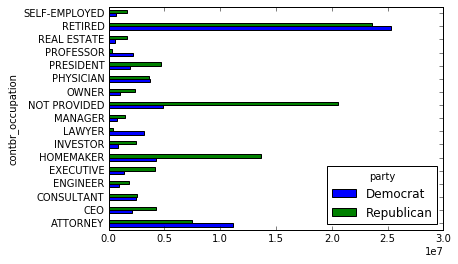

In [97]:
over_2mm.plot(kind='barh')

了解Obama和Romney总出资最高的职业和企业。

先对候选人分组，然后使用本章介绍的求取最大值的方法：

In [107]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()
    
    # 根据key对totals进行降序排列
    return totals.sort_values(ascending=False)[:n]

In [108]:
# 根据职业和雇主进行聚合：
grouped = fec_mrbo.groupby('cand_nm')

grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

cand_nm        contbr_occupation                     
Obama, Barack  RETIRED                                   25305116.38
               ATTORNEY                                  11141982.97
               INFORMATION REQUESTED                      4866973.96
               HOMEMAKER                                  4248875.80
               PHYSICIAN                                  3735124.94
               LAWYER                                     3160478.87
               CONSULTANT                                 2459912.71
Romney, Mitt   RETIRED                                   11508473.59
               INFORMATION REQUESTED PER BEST EFFORTS    11396894.84
               HOMEMAKER                                  8147446.22
               ATTORNEY                                   5364718.82
               PRESIDENT                                  2491244.89
               EXECUTIVE                                  2300947.03
               C.E.O.                            

In [109]:
grouped.apply(get_top_amounts, 'contbr_employer', n=10)

cand_nm        contbr_employer                       
Obama, Barack  RETIRED                                   22694358.85
               SELF-EMPLOYED                             17080985.96
               NOT EMPLOYED                               8586308.70
               INFORMATION REQUESTED                      5053480.37
               HOMEMAKER                                  2605408.54
               SELF                                       1076531.20
               SELF EMPLOYED                               469290.00
               STUDENT                                     318831.45
               VOLUNTEER                                   257104.00
               MICROSOFT                                   215585.36
Romney, Mitt   INFORMATION REQUESTED PER BEST EFFORTS    12059527.24
               RETIRED                                   11506225.71
               HOMEMAKER                                  8147196.22
               SELF-EMPLOYED                     

### 对出资额分组
利用cut函数根据出资额的大小将数据离散化到多个面元中：

In [111]:
bins = np.array([0, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000])
labels = pd.cut(fec_mrbo.contb_receipt_amt, bins)
labels

411           (10, 100]
412         (100, 1000]
413         (100, 1000]
414           (10, 100]
415           (10, 100]
416           (10, 100]
417         (100, 1000]
418           (10, 100]
419         (100, 1000]
420           (10, 100]
421           (10, 100]
422         (100, 1000]
423         (100, 1000]
424         (100, 1000]
425         (100, 1000]
426         (100, 1000]
427       (1000, 10000]
428         (100, 1000]
429         (100, 1000]
430           (10, 100]
431       (1000, 10000]
432         (100, 1000]
433         (100, 1000]
434         (100, 1000]
435         (100, 1000]
436         (100, 1000]
437           (10, 100]
438         (100, 1000]
439         (100, 1000]
440           (10, 100]
              ...      
701356        (10, 100]
701357          (1, 10]
701358        (10, 100]
701359        (10, 100]
701360        (10, 100]
701361        (10, 100]
701362      (100, 1000]
701363        (10, 100]
701364        (10, 100]
701365        (10, 100]
701366        (1

In [113]:
# 然后根据候选人姓名以及面元标签对数据进行分组：
grouped = fec_mrbo.groupby(['cand_nm', labels])
grouped.size().unstack(0)
# 从这个数据看出，小额Obama获得比较多赞助

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493.0,77.0
"(1, 10]",40070.0,3681.0
"(10, 100]",372280.0,31853.0
"(100, 1000]",153991.0,43357.0
"(1000, 10000]",22284.0,26186.0
"(10000, 100000]",2.0,1.0
"(100000, 1000000]",3.0,NaN
"(1000000, 10000000]",4.0,NaN


In [ ]:
# 对出资额求和并在面元内规格化，以便图形化显示两位候选人各种赞助额度的比例：